In [3]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import seaborn as sns

%matplotlib inline
import hvplot.pandas
import plotly.express as px
import panel as pn


Bad key "text.kerning_factor" on line 4 in
/Users/stevencherryii/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

In [5]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [6]:
ticker = ["SPY", "AGG",'IAU', "USO", "QQQ"]
# Set timeframe to '1D'
timeframe = "1D"
# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2009-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)


In [7]:
#change index strucutre
from datetime import datetime
df.index = df.index.strftime('%Y-%m-%d')
df.index = pd.to_datetime(df.index)
df.columns = ['AGG','IAU','QQQ','SPY','USO']
df['2010-06-20':'2010-06-25']

AGG      IAU    QQQ     SPY    USO
2010-06-21  106.21   12.051  42.64  111.36  35.30
2010-06-22  106.39   12.149  42.31  109.57  35.02
2010-06-23  106.71  121.060  46.06  109.21  34.23
2010-06-24  106.62   12.140  45.34  107.44  34.39
2010-06-25  106.71   12.290  45.26  107.89  35.66

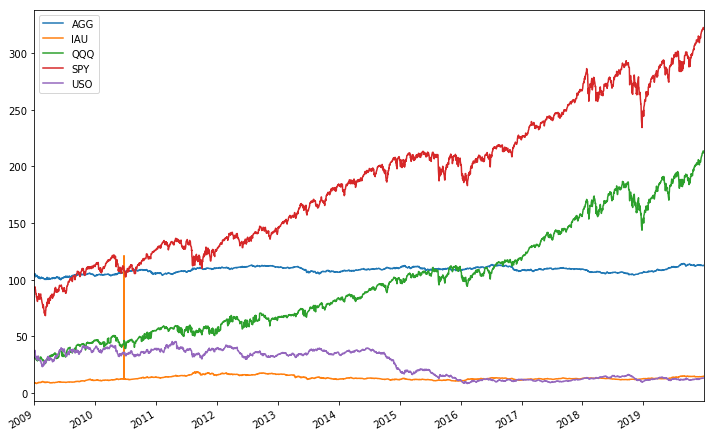

In [8]:
#correct wrong value
#into hvplot
df.plot(figsize = (12,8))
#As we can see from the plot, there is an apparent outlier which happens in every data processing.
# After cross-validating with Yahoo Finance, we modified this outlier into correct value
df['IAU'] = df['IAU'].replace(df['IAU'].max(), 12.106)


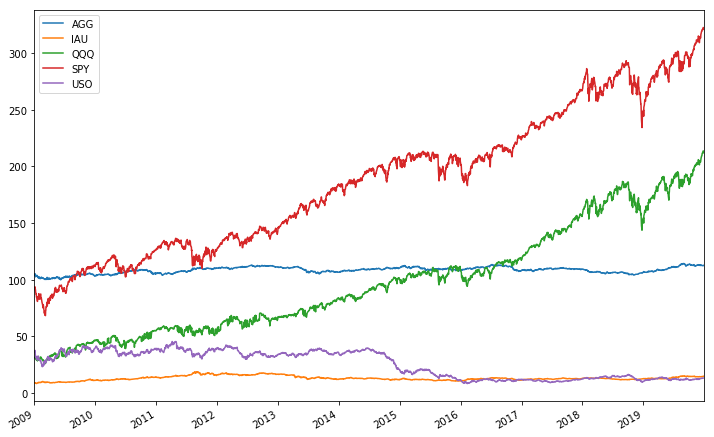

In [9]:
#double check and re-plot
df['2010-06-20':'2010-06-25']
df.plot(figsize = (12,8))

In [10]:
#Monthly data transformation
monthly_df=df.resample('M').mean()
#kind of wired, change the columns 
monthly_df.columns = ['AGG','IAU','QQQ','SPY','USO']

In [11]:
monthly_df.head()

AGG       IAU        QQQ        SPY        USO
2009-01-31  102.894315  8.500000  29.656005  86.572000  31.731000
2009-02-28  101.345179  9.269316  29.524211  80.757842  26.243158
2009-03-31  100.688255  9.118455  28.727727  75.975455  28.819727
2009-04-30  101.006810  8.762048  32.750952  84.885714  28.985714
2009-05-31  101.547495  9.135400  32.421000  90.507000  32.670525

Text(0, 0.5, 'price in $')

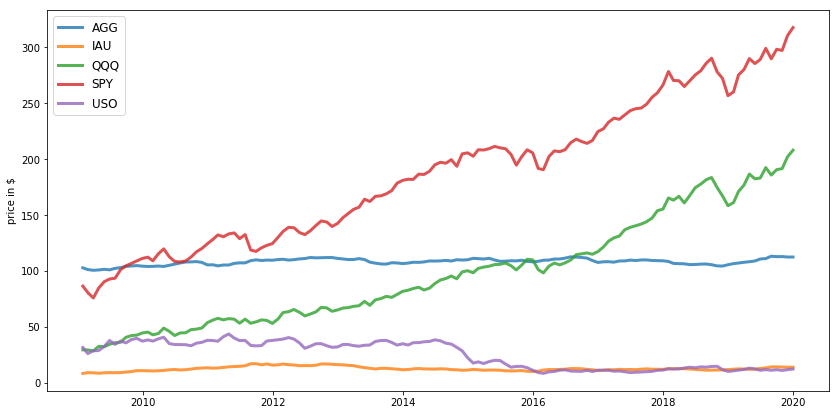

In [12]:
#Add plot here
plt.figure(figsize=(14, 7))
for c in monthly_df.columns.values:
    plt.plot(monthly_df.index, monthly_df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [13]:
corr=monthly_df.corr()
corr

AGG       IAU       QQQ       SPY       USO
AGG  1.000000  0.591396  0.343733  0.394646 -0.316596
IAU  0.591396  1.000000 -0.043639 -0.053647  0.269738
QQQ  0.343733 -0.043639  1.000000  0.988227 -0.825427
SPY  0.394646 -0.053647  0.988227  1.000000 -0.820875
USO -0.316596  0.269738 -0.825427 -0.820875  1.000000

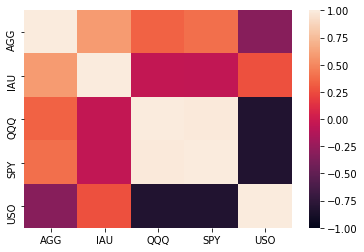

In [14]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, vmin=-1, vmax=1)

In [15]:
corr.hvplot.heatmap(title='Correlation Between ETFs')

:HeatMap   [columns,index]   (value)

In [16]:
# Calculate the monthly returns for the stocks
monthly_returns = monthly_df.pct_change().dropna()

# Display sample data
monthly_returns.head()

AGG       IAU       QQQ       SPY       USO
2009-02-28 -0.015056  0.090508 -0.004444 -0.067160 -0.172949
2009-03-31 -0.006482 -0.016275 -0.026977 -0.059219  0.098181
2009-04-30  0.003164 -0.039086  0.140047  0.117278  0.005759
2009-05-31  0.005353  0.042610 -0.010075  0.066222  0.127125
2009-06-30 -0.004383  0.017446  0.067476  0.026181  0.162621

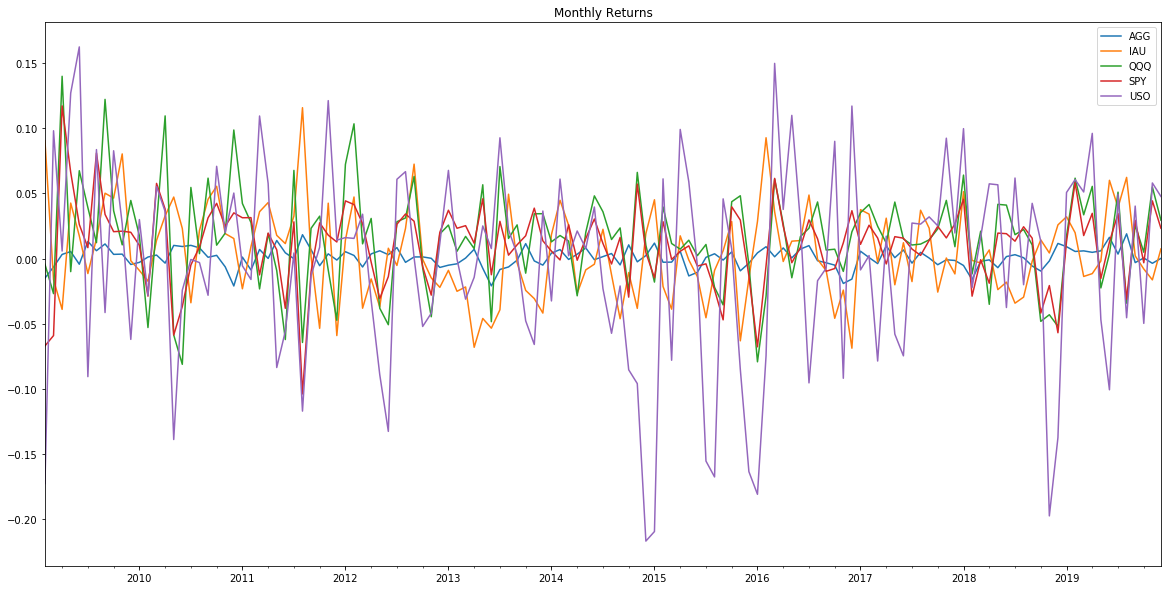

In [17]:
#plot monthly returns
monthly_returns.plot(figsize=(20,10), title='Monthly Returns')

In [18]:
monthly_returns.hvplot(title="Monthly Returns")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [19]:
#plot daily return
returns=df.pct_change().dropna()
returns.columns=['AGG','IAU','QQQ','SPY','USO']
returns.head()

AGG       IAU       QQQ       SPY       USO
2009-01-05  0.013952 -0.021772 -0.000322 -0.001829  0.046042
2009-01-06 -0.005703  0.008879  0.009674  0.006897 -0.000268
2009-01-07 -0.008700 -0.028280 -0.027787 -0.029324 -0.107919
2009-01-08 -0.008969  0.020891  0.010844  0.004190 -0.001204
2009-01-09 -0.003503 -0.006151 -0.022428 -0.022727 -0.025008

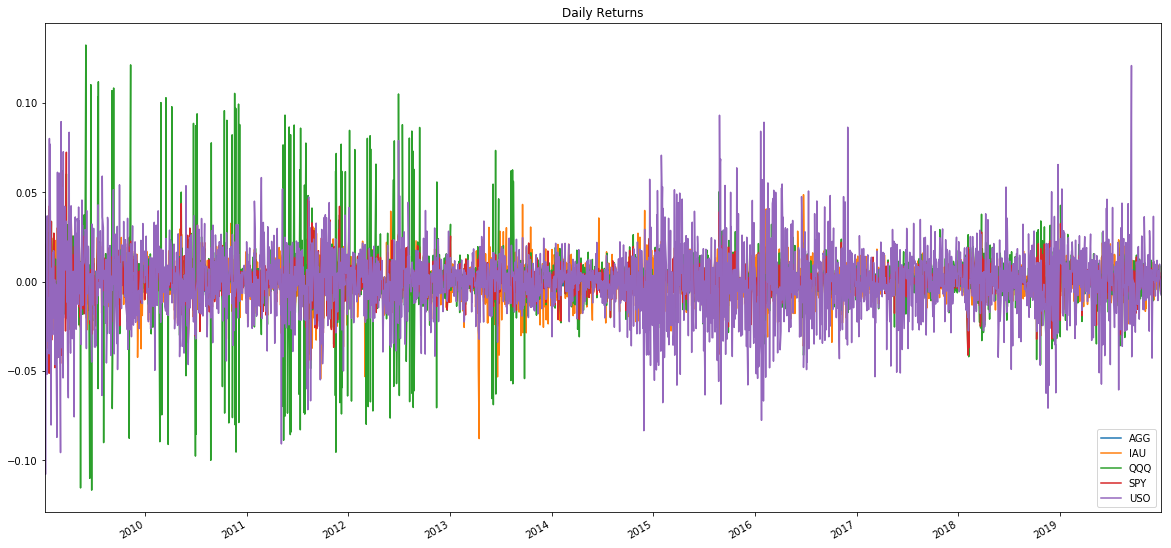

In [20]:
returns.plot(figsize=(20,10), title='Daily Returns')

In [21]:
returns.hvplot(title='Daily Returns')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [22]:
# Compute monthly volatility
monthly_volatility = monthly_returns.std()
agg_volatility = monthly_volatility["AGG"]
iau_volatility = monthly_volatility["IAU"]
qqq_volatility = monthly_volatility["QQQ"]
spy_volatility = monthly_volatility["SPY"]
uso_volatility = monthly_volatility["USO"]

In [23]:
monthly_volatility

AGG    0.007361
IAU    0.034658
QQQ    0.039045
SPY    0.030525
USO    0.076636
dtype: float64

In [24]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [25]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights = weights/np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [26]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    #created equally weighted portfolio 
    equal_wei_std, equal_wei_returns = portfolio_annualised_performance(np.array([0.2,0.2,0.2,0.2,0.2]),mean_returns,cov_matrix)

    
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    max_return_idx = np.argmax(results[1])
    sd_max,r_max = results[0,max_return_idx],results[1,max_return_idx]
    max_ret_allocation = pd.DataFrame(weights[max_return_idx],index=df.columns,columns=['allocation'])
    max_ret_allocation.allocation = [round(i*100,2)for i in max_ret_allocation.allocation]
    max_ret_allocation = max_ret_allocation.T
    
    
    
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Maximum Return Portfolio Allocation\n")
    print("Annualised Return:", round(r_max,2))
    print("Annualised Volatility:", round(sd_max,2))
    print("\n")
    print(max_ret_allocation)
    
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.scatter(sd_max,r_max,marker = "*", color = "black", s = 500, label='Maximum return')
    plt.scatter(equal_wei_std,equal_wei_returns,marker = '*', color = "b", s = 500, label = "Equally weighted Portfolio")
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [27]:
#data preparation and input. Here we use monthly return since we have more than 10-years data
returns = df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 250000
#three-month U.S. Treasury bill 
risk_free_rate = 0.001
monthly_return = monthly_df.mean()
monthly_cov_matrix= monthly_df.cov()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.07
Annualised Volatility: 0.07


              AGG    IAU  QQQ   SPY  USO
allocation  47.69  13.91  8.6  29.7  0.1
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.02
Annualised Volatility: 0.03


              AGG   IAU   QQQ   SPY  USO
allocation  88.53  3.26  3.07  4.64  0.5
--------------------------------------------------------------------------------
Maximum Return Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.3


             AGG  IAU    QQQ   SPY   USO
allocation  2.22  1.2  94.16  1.01  1.41


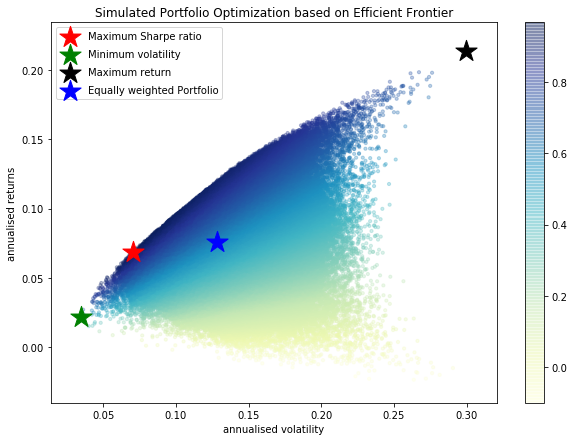

In [28]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 21708.78
Annualised Volatility: 37.21


              AGG   IAU   QQQ   SPY    USO
allocation  72.45  6.86  1.89  0.17  18.63
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 6643.08
Annualised Volatility: 32.06


              AGG    IAU   QQQ   SPY   USO
allocation  11.66  81.71  1.25  0.47  4.91
--------------------------------------------------------------------------------
Maximum Return Portfolio Allocation

Annualised Return: 43996.19
Annualised Volatility: 869.04


              AGG   IAU   QQQ    SPY   USO
allocation  12.13  0.51  0.66  85.85  0.85


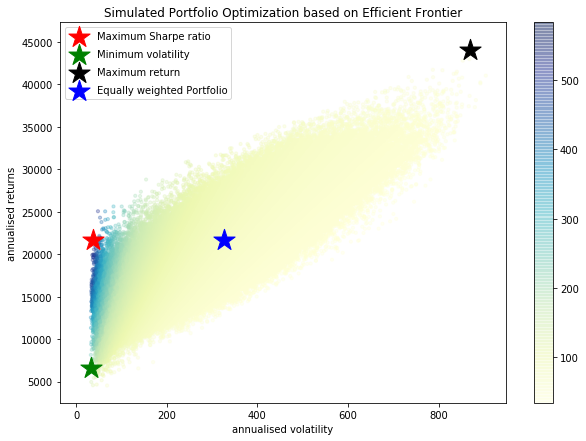

In [40]:
display_simulated_ef_with_random(monthly_return, monthly_cov_matrix, num_portfolios, risk_free_rate)

In [29]:
# Monte Carlo by monthly data
num_simulations = 100
num_trading_days = 252
monthly_return = monthly_df.pct_change()
avg_agg = monthly_return['AGG'].mean()
avg_iau = monthly_return['IAU'].mean()
avg_qqq = monthly_return['QQQ'].mean()
avg_spy = monthly_return['SPY'].mean()
avg_uso = monthly_return['USO'].mean()

std_agg = monthly_return['AGG'].std()
std_iau = monthly_return['IAU'].std()
std_qqq = monthly_return['QQQ'].std()
std_spy = monthly_return['SPY'].std()
std_uso = monthly_return['USO'].std()

agg_last_price = monthly_df['AGG'][-1]
iau_last_price = monthly_df['IAU'][-1]
qqq_last_price = monthly_df['QQQ'][-1]
spy_last_price = monthly_df['SPY'][-1]
uso_last_price = monthly_df['USO'][-1]
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()
for n in range(num_simulations):
    simulated_agg_prices = [agg_last_price]
    simulated_iau_prices = [iau_last_price]
    simulated_qqq_prices = [qqq_last_price]
    simulated_spy_prices = [spy_last_price]
    simulated_uso_prices = [uso_last_price]
    for i in range(num_trading_days):
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_agg, std_agg))
        simulated_iau_price = simulated_iau_prices[-1] * (1 + np.random.normal(avg_iau, std_iau))
        simulated_qqq_price = simulated_qqq_prices[-1] * (1 + np.random.normal(avg_qqq, std_qqq))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_spy, std_spy))
        simulated_uso_price = simulated_uso_prices[-1] * (1 + np.random.normal(avg_uso, std_uso))
        simulated_agg_prices.append(simulated_agg_price)
        simulated_iau_prices.append(simulated_iau_price)
        simulated_qqq_prices.append(simulated_qqq_price)
        simulated_spy_prices.append(simulated_spy_price)
        simulated_uso_prices.append(simulated_uso_price)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["IAU prices"] = pd.Series(simulated_iau_prices)
    simulated_price_df["QQQ prices"] = pd.Series(simulated_qqq_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["USO prices"] = pd.Series(simulated_uso_prices)
    simulated_daily_returns = simulated_price_df.pct_change()
    weights = [0.7245,0.0686,0.0189,0.0017,0.1863]
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [30]:
#result checking_similated prices
simulated_price_df.head()

AGG prices  IAU prices  QQQ prices  SPY prices  USO prices
0  112.548095   14.166667  207.971429  317.497595   12.497619
1  113.631350   14.338111  218.900976  334.939046   13.731168
2  113.266800   14.195574  224.220159  337.115777   14.340705
3  112.574194   14.988548  233.241940  342.150246   14.362487
4  113.207918   15.132594  248.353068  326.962471   14.424831

In [31]:
#result checking_similated retruns based on optimized weights
portfolio_cumulative_returns.head()

0         1         2         3         4         5         6   \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  0.991798  1.002543  0.985099  1.026152  0.993383  1.003379  0.992223   
2  0.998794  1.003078  0.959690  1.052359  0.985070  0.978101  0.997043   
3  0.995514  1.001013  0.966077  1.071485  0.985119  0.984439  1.015272   
4  0.994419  1.008870  0.959048  1.048894  0.979599  0.990629  1.002380   

         7         8         9   ...        90        91        92        93  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  0.998561  1.019461  0.991548  ...  0.989093  1.005915  1.012215  1.001733   
2  1.010516  1.016034  0.980316  ...  1.006496  1.024435  1.041361  0.992582   
3  1.007718  1.001924  1.007123  ...  0.997487  1.015620  1.007839  0.982666   
4  1.029519  0.963301  1.024620  ...  0.970345  1.006544  1.038122  0.990557   

         94        95        96        97        98        99  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  1.009103  1.025074  1.004298  0.986704  1.001185  1.027280  
2  1.001922  1.045734  0.993679  1.000497  1.010508  1.033170  
3  1.019960  1.064362  0.988740  1.039849  1.020629  1.033655  
4  0.996417  1.069277  0.971854  1.053469  1.006697  1.040577  

[5 rows x 100 columns]

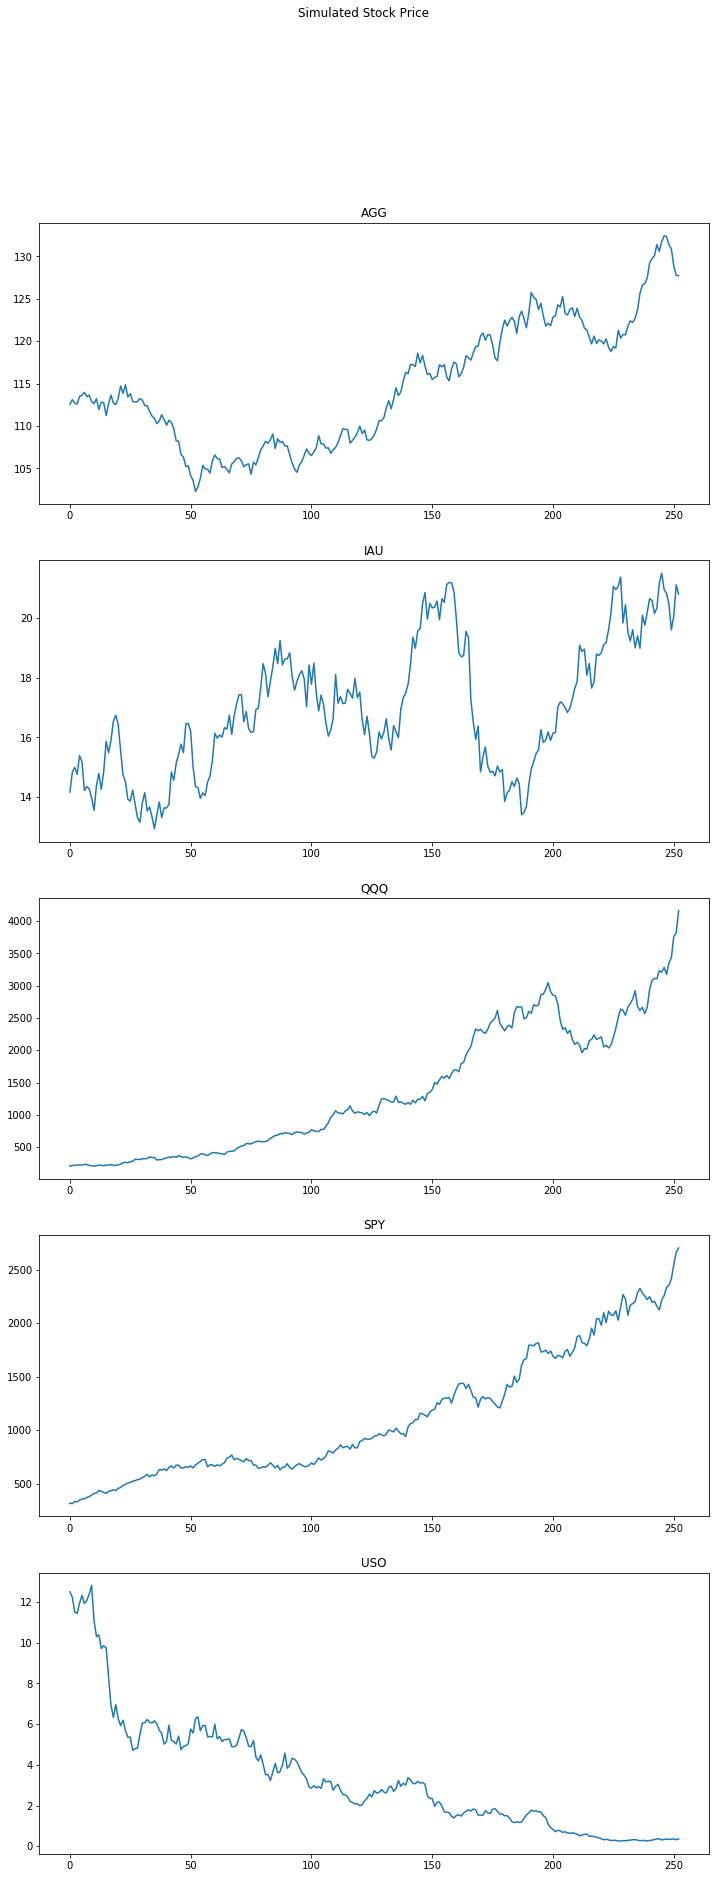

In [77]:
fig, axs = plt.subplots(5,figsize = (12,30))
fig.suptitle('Simulated Stock Price')
axs[0].plot(simulated_price_df['AGG prices'].index, simulated_price_df['AGG prices'])
axs[1].plot(simulated_price_df['IAU prices'].index, simulated_price_df['IAU prices'])
axs[2].plot(simulated_price_df['QQQ prices'].index, simulated_price_df['QQQ prices'])
axs[3].plot(simulated_price_df['SPY prices'].index, simulated_price_df['SPY prices'])
axs[4].plot(simulated_price_df['USO prices'].index, simulated_price_df['USO prices'])
axs[0].title.set_text('AGG')
axs[1].title.set_text('IAU')
axs[2].title.set_text('QQQ')
axs[3].title.set_text('SPY')
axs[4].title.set_text('USO')


In [35]:
simulated_price_df['AGG prices'].hvplot()

:Curve   [index]   (AGG prices)

In [36]:
simulated_price_df['IAU prices'].hvplot()

:Curve   [index]   (IAU prices)

In [38]:
simulated_price_df['QQQ prices'].hvplot()

:Curve   [index]   (QQQ prices)

In [37]:
simulated_price_df['SPY prices'].hvplot()

:Curve   [index]   (SPY prices)

In [39]:
simulated_price_df['USO prices'].hvplot()

:Curve   [index]   (USO prices)

In [45]:
simulated_price_df.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

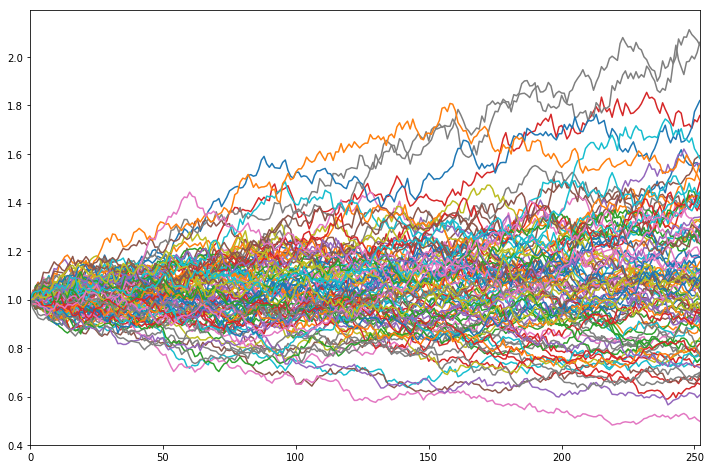

In [33]:
portfolio_cumulative_returns.plot(legend = False,figsize = (12,8))

In [44]:
portfolio_cumulative_returns.hvplot(title="portfolio cumulative returns",height=400)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [80]:
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.689107
0.975    1.578049
Name: 252, dtype: float64

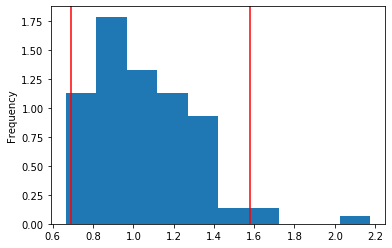

In [81]:
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [24]:
simulated_price_df.plot()

/Users/fred/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:


/Users/fred/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:1832: RuntimeWarning: overflow encountered in double_scalars
  dv = abs(vmax - vmin)  # > 0 as nonsingular is called before.
/Users/fred/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2038: RuntimeWarning: overflow encountered in double_scalars
  raw_step = (_vmax - _vmin) / nbins
/Users/fred/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2045: RuntimeWarning: invalid value encountered in greater_equal
  istep = np.nonzero(steps >= raw_step)[0][0]


IndexError: index 0 is out of bounds for axis 0 with size 0